In [1]:
### Import Required Libraries

import sys  
sys.path.insert(0, '../../workspace/')
import os, os.path as osp
import pandas as pd
import pydicom
from tqdm import tqdm
import json
import re
import pickle
from sklearn.model_selection import StratifiedKFold, KFold
import sklearn
import numpy as np

import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', 400)

In [2]:
cd /home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto

/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto


In [134]:
ds = pydicom.dcmread('../cspine-det/data/dicoms_072919/Csp_00069_20130630/IM-2277-0001.dcm')
ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY']
(0008, 0012) Instance Creation Date              DA: ''
(0008, 0016) SOP Class UID                       UI: Computed Radiography Image Storage
(0008, 0018) SOP Instance UID                    UI: 2.16.840.1.113669.632.21.1396024793.1396024793.15404579682698940
(0008, 0020) Study Date                          DA: '20130630'
(0008, 0021) Series Date                         DA: '20130630'
(0008, 0022) Acquisition Date                    DA: ''
(0008, 0023) Content Date                        DA: ''
(0008, 0030) Study Time                          TM: '144118.546'
(0008, 0031) Series Time                         TM: '144342.656'
(0008, 0032) Acquisition Time                    TM: '144342.656'
(0008, 0033) Content Time                        TM: '144342.656'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality               

# Quick function to show dcm image

In [135]:
def show_image (filename):
    ds = pydicom.dcmread(filename)
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)

# Include study description to compare with train_labels_with_splits

In [136]:
# from cspine_hardware/cspine-det/src/etl/1_parse_dicom_uids.py

DICOM_DIR = '../cspine-det/data/dicoms_072919/' #Path where DICOM files are stored

#Dictionary to store DICOM files
dcm_dict = {
    'filepath': [],
    'SOPClassUID': [],
    'SOPInstanceUID' : [],
    'StudyDate': [],
    'Modality': [],
    'StudyDescription': [],
    'SeriesDescription': [],
    'PatientID': [],
    "Patient'sBirthDate": [],
    "Patient'sSex": [],
    'BodyPartExamined': [],
    'ViewPosition': [],
    'StudyInstanceUID':[],
    'SeriesInstanceUID':[],
    'PatientOrientation': []    
}

#Function to extract data from DICOM files:
def try_to_access(dcm, name):
    try:
        if name=='height':
            return (dcm.pixel_array.shape[0])
        elif name == 'width':
            return (dcm.pixel_array.shape[1])
        else:
            return(getattr(dcm, name))
    except:
        return(None)

for root, dirs, files in tqdm(os.walk(DICOM_DIR, topdown=True)):
    for f in files:
        filename = osp.join(root,f)
        dcm_dict['filepath'].append(filename.replace('../../data/',''))
        dcm = pydicom.dcmread(filename)
        dcm_dict['SOPClassUID'].append(try_to_access(dcm, 'SOPClassUID'))
        dcm_dict['SOPInstanceUID'].append(try_to_access(dcm, 'SOPInstanceUID'))
        dcm_dict['StudyDate'].append(try_to_access(dcm,'StudyDate'))
        dcm_dict['Modality'].append(try_to_access(dcm, 'Modality'))
        dcm_dict['StudyDescription'].append(try_to_access(dcm, 'StudyDescription'))
        dcm_dict['SeriesDescription'].append(try_to_access(dcm, 'SeriesDescription'))
        dcm_dict['PatientID'].append(try_to_access(dcm, 'PatientID'))
        dcm_dict["Patient'sBirthDate"].append(try_to_access(dcm, "Patient'sBirthDate"))
        dcm_dict["Patient'sSex"].append(try_to_access(dcm, "Patient'sSex"))
        dcm_dict['BodyPartExamined'].append(try_to_access(dcm,'BodyPartExamined'))
        dcm_dict['ViewPosition'].append(try_to_access(dcm,'ViewPosition'))
        dcm_dict['StudyInstanceUID'].append(try_to_access(dcm, 'StudyInstanceUID'))
        dcm_dict['SeriesInstanceUID'].append(try_to_access(dcm, 'SeriesInstanceUID'))
        dcm_dict['PatientOrientation'].append(try_to_access(dcm, 'PatientOrientation'))
                                                      
dcm_df = pd.DataFrame(dcm_dict) #Save DICOM data to dataframe
dcm_df.to_csv('/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/DataExploration/DICOM_Extract_v2.csv', index=False) #Save as a CSV file                        

1253it [00:10, 118.14it/s]


In [137]:
dcm_df = pd.read_csv('/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/DataExploration/DICOM_Extract_v2.csv', index_col=None)
# Convert study date to dateformate
dcm_df['StudyDate']=pd.to_datetime(dcm_df['StudyDate'], format='%Y%m%d')

print(f'Shape of dataframe:\t{dcm_df.shape}\n')
study_types = dcm_df['StudyDescription'].unique()
print('Studies to be removed:CT SPINE CERVICAL W CONTRAST, XR SPINE CERVICAL COMP OBLIQ FLEXEXT, XR SPINE CERVICAL COMP FLEXEXT, XR SPINE CERVICAL MYELOGRAM, XR SPINE MYELOGRAM CERV THOR')

# only include appropriate studies
studies = ['XR SPINE CERVICAL 2-3 VIEWS', 'XR Spine Cervical 4-5 Views','XR SPINE CERVICAL 1 VIEW', 'XR SPINE CERVICAL 4-5 VIEWS' 'XR SPINE CERVICAL 4 VIEWS', 'XR SPINE CERVICAL 2-3 VWS STND PROTOCOL', 'XR Spine Cervical 2-3 Vws Stnd Protocol', 'XR Spine Cervical 2-3 Views']
dcm_df = dcm_df[dcm_df['StudyDescription'].isin(studies)]

# Display head and shape of data
display(dcm_df.head())
print(f'After removal of studies, shape of dataframe:\t{dcm_df.shape}')
print(f'Unique patients {len(dcm_df["PatientID"].unique())}')

Shape of dataframe:	(4829, 15)

Studies to be removed:CT SPINE CERVICAL W CONTRAST, XR SPINE CERVICAL COMP OBLIQ FLEXEXT, XR SPINE CERVICAL COMP FLEXEXT, XR SPINE CERVICAL MYELOGRAM, XR SPINE MYELOGRAM CERV THOR


,filepath,SOPClassUID,SOPInstanceUID,StudyDate,Modality,StudyDescription,SeriesDescription,PatientID,Patient'sBirthDate,Patient'sSex,BodyPartExamined,ViewPosition,StudyInstanceUID,SeriesInstanceUID,PatientOrientation
0,../cspine-det/data/dicoms_072919/Csp_00069_20130127/IM-2418-0001.dcm,1.2.840.10008.5.1.4.1.1.1,2.16.840.1.113669.632.21.1396024793.1396024793.34523878562548110,2013-01-27,CR,XR SPINE CERVICAL 2-3 VIEWS,AP,CSP_00069,NaN,NaN,C SPINE,AP,2.16.840.1.113669.632.21.1396024793.1396024793.26159062962046250,2.16.840.1.113669.632.21.1396024793.1396024793.34356800212136354,"['L', 'F']"
1,../cspine-det/data/dicoms_072919/Csp_00069_20130127/IM-2419-0001.dcm,1.2.840.10008.5.1.4.1.1.1,2.16.840.1.113669.632.21.1396024793.1396024793.22817195932698770,2013-01-27,CR,XR SPINE CERVICAL 2-3 VIEWS,LATERAL,CSP_00069,NaN,NaN,C SPINE,LATERAL,2.16.840.1.113669.632.21.1396024793.1396024793.26159062962046250,2.16.840.1.113669.632.21.1396024793.1396024793.22994831802286994,"['L', 'F']"
2,../cspine-det/data/dicoms_072919/Csp_00173_20140802/IM-1884-0001.dcm,1.2.840.10008.5.1.4.1.1.1,2.16.840.1.113669.632.21.1110812115.1110812115.33724596022427400,2014-08-02,CR,XR SPINE CERVICAL 2-3 VIEWS,LATERAL,CSP_00173,NaN,NaN,C SPINE,LATERAL,2.16.840.1.113669.632.21.1110812115.1110812115.37611566072016400,2.16.840.1.113669.632.21.1110812115.1110812115.33562637672005680,"['A', 'F']"
3,../cspine-det/data/dicoms_072919/Csp_00173_20140802/IM-1883-0001.dcm,1.2.840.10008.5.1.4.1.1.1,2.16.840.1.113669.632.21.1110812115.1110812115.33723285302407380,2014-08-02,CR,XR SPINE CERVICAL 2-3 VIEWS,AP,CSP_00173,NaN,NaN,C SPINE,AP,2.16.840.1.113669.632.21.1110812115.1110812115.37611566072016400,2.16.840.1.113669.632.21.1110812115.1110812115.33557435752075830,"['L', 'F']"
4,../cspine-det/data/dicoms_072919/Csp_00173_20140802/IM-1882-0001.dcm,1.2.840.10008.5.1.4.1.1.1,2.16.840.1.113669.632.21.1110812115.1110812115.33760202882547760,2014-08-02,CR,XR SPINE CERVICAL 2-3 VIEWS,LATERAL EXT,CSP_00173,NaN,NaN,C SPINE,LATERAL EXT,2.16.840.1.113669.632.21.1110812115.1110812115.38064703992036250,2.16.840.1.113669.632.21.1110812115.1110812115.33589064372125850,"['A', 'F']"


After removal of studies, shape of dataframe:	(2942, 15)
Unique patients 190


In [138]:
# Check if values are missing
print(f'\nCol: filepath Missing:\t\t {len(dcm_df[dcm_df["filepath"].isna()])}')
      
print(f'\nCol: filepath SOPClassUID:\t {len(dcm_df[dcm_df["SOPClassUID"].isna()])}')

print(f'\nCol: filepath SOPInstanceUID:\t {len(dcm_df[dcm_df["SOPInstanceUID"].isna()])}')

print(f'\nCol: filepath StudyDate:\t {len(dcm_df[dcm_df["StudyDate"].isna()])}')

print(f'\nCol: Modality Missing:\t\t {len(dcm_df[dcm_df["Modality"].isna()])}')

print(f'\nCol: StudyDescription Missing:\t {len(dcm_df[dcm_df["StudyDescription"].isna()])}')

print(f'\nCol: SeriesDescription Missing:\t {len(dcm_df[dcm_df["SeriesDescription"].isna()])}')
      
print(f'\nCol: PatientID Missing:\t\t {len(dcm_df[dcm_df["PatientID"].isna()])}')

print('\nCol: PatientsBirthDate Missing:\t', len(dcm_df[dcm_df["Patient'sBirthDate"].isna()]))

print('\nCol: PatientsSex Missing:\t', len(dcm_df[dcm_df["Patient'sSex"].isna()]))
      
print(f'\nCol: BodyPartExamined Missing:\t {len(dcm_df[dcm_df["BodyPartExamined"].isna()])}')
      
print(f'\nCol: ViewPosition Missing:\t {len(dcm_df[dcm_df["ViewPosition"].isna()])}')
      
print(f'\nCol: StudyInstanceUID Missing:\t {len(dcm_df[dcm_df["StudyInstanceUID"].isna()])}')
      
print(f'\nCol: SeriesInstanceUID Missing:\t {len(dcm_df[dcm_df["SeriesInstanceUID"].isna()])}')
      
print(f'\nCol: PatientOrientation Missing: {len(dcm_df[dcm_df["PatientOrientation"].isna()])}')


Col: filepath Missing:		 0

Col: filepath SOPClassUID:	 0

Col: filepath SOPInstanceUID:	 0

Col: filepath StudyDate:	 0

Col: Modality Missing:		 0

Col: StudyDescription Missing:	 0

Col: SeriesDescription Missing:	 487

Col: PatientID Missing:		 0

Col: PatientsBirthDate Missing:	 2942

Col: PatientsSex Missing:	 2942

Col: BodyPartExamined Missing:	 0

Col: ViewPosition Missing:	 489

Col: StudyInstanceUID Missing:	 0

Col: SeriesInstanceUID Missing:	 0

Col: PatientOrientation Missing: 503


In [139]:
# Read Excel sheet for mapping brands to patients
df = pd.read_excel('/home/judy/devbox/cspine_hardware/hdw_merged_anon_final.xlsx', index_col=None)

# Get rid of 'Unnamed' columns
df = df[[col for col in df.columns if not re.search('Unnamed', col)]].drop_duplicates().reset_index(drop=True)

# Now, make presence/absence of hardware labels based on Anonymized DOS
patient_df = df[['AnonymizedPatientID', 'Anonymized DOS', 'Anterior HDW', 'Posterior HDW', 'Cage']]
patient_df = patient_df.drop_duplicates().reset_index(drop=True)
# Rename PatientID column to make the merge easier
patient_df = patient_df.rename(columns={'AnonymizedPatientID':'PatientID'})

# Note: Patient CSP_00015 seems to have had their Anterior HDW changed from one brand to another, with xrays for both
# present in the dataset. This means all images for this patient are currently labeled with 2 brands.
# Treat patient before second surgery as CSP_00015 and treat patient after second surgery as a new patient CSP00191
# ***Assumption: any images the day of the surgery were pre-surgery and should be labeled as Atlantis
patient_df.at[15, 'PatientID'] = 'CSP_00191'

print(f'Unique patients in dataset:\t {len(patient_df["PatientID"].unique())}')
# Exclude records with no hardware
patient_df =patient_df[(patient_df['Anterior HDW'].notna()) | (patient_df['Posterior HDW'].notna()) | (patient_df['Cage'].notna())]

print(f'Unique patients in dataset that have hardware:\t {len(patient_df["PatientID"].unique())}')
display(patient_df.head())
print(patient_df.shape)

Unique patients in dataset:	 191
Unique patients in dataset that have hardware:	 187


,PatientID,Anonymized DOS,Anterior HDW,Posterior HDW,Cage
0,CSP_00001,2010-06-04,ATLANTIS,NaN,NaN
1,CSP_00002,2009-11-20,ATLANTIS,NaN,NaN
2,CSP_00003,2009-12-28,ATLANTIS,NaN,NaN
3,CSP_00004,2010-01-18,NaN,Vertex,Nuvasive
4,CSP_00005,2010-04-30,ATLANTIS,NaN,NaN


(187, 5)


In [140]:
# Step 1: join tables on patient ID
temp_branded_dcm = pd.merge(dcm_df, patient_df, on='PatientID', how='left')
branded_dcm = pd.merge(dcm_df, patient_df, on='PatientID')
branded_dcm.loc[(branded_dcm['StudyDate'] > '2015-09-01') & (branded_dcm['PatientID']=='CSP_00015'), 'Anterior HDW'] = 'ZEVO'
branded_dcm.loc[(branded_dcm['StudyDate'] > '2015-09-01') & (branded_dcm['PatientID']=='CSP_00015'), 'PatientID'] = 'CSP_00191'
branded_dcm.loc[(branded_dcm['Anterior HDW'] =='ATLANTIS '), 'Anterior HDW'] = 'ATLANTIS'
branded_dcm['Anonymized DOS']=pd.to_datetime(branded_dcm['Anonymized DOS'], format='%Y%m%d')

print(f'The following patients are not in brands file: {temp_branded_dcm[temp_branded_dcm["Anterior HDW"].isna() & temp_branded_dcm["Posterior HDW"].isna() & temp_branded_dcm["Cage"].isna()]["PatientID"].unique()} which further reduces study data from {dcm_df.shape} to {branded_dcm.shape}.')

The following patients are not in brands file: ['CSP_00134' 'CSP_00099' 'CSP_00061' 'CSP_00188'] which further reduces study data from (2942, 15) to (2889, 19).


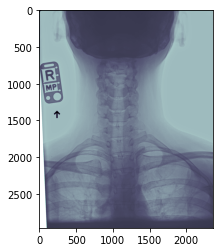

In [141]:
# Example of patient CSP_00173 before and after surgery
show_image('../cspine-det/data/dicoms_072919/Csp_00173_20140525/IM-1928-1001.dcm')


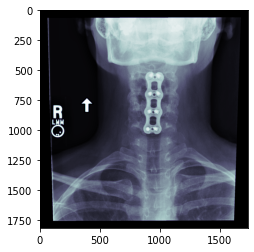

In [142]:
show_image('../cspine-det/data/dicoms_072919/Csp_00173_20140802/IM-1883-0001.dcm')

In [143]:
# Step 2: only take images after DOS
# Do not currently take images before DOS as 'no hardware' because we are unsure if they came in with some hardware
# **Question for Dr Trivedi: do patients ever come in with hardware before DOS?
branded_dcm = branded_dcm[branded_dcm['StudyDate'] > branded_dcm['Anonymized DOS']]
print(f'\nRecords reduced to {branded_dcm.shape} after removing study dates that were before date of surgery')
print(f'\nUnique patients: {len(branded_dcm["PatientID"].unique())}')


Records reduced to (2185, 19) after removing study dates that were before date of surgery

Unique patients: 186


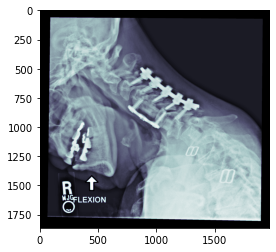

In [144]:
# Multiple implants
show_image('../cspine-det/data/dicoms_072919/Csp_00095_20141004/IM-1832-0001.dcm')

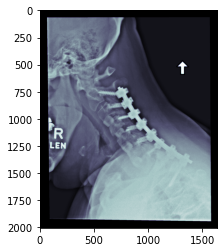

In [145]:
# Single implant
branded_dcm[(branded_dcm["Anterior HDW"].isna() & branded_dcm["Posterior HDW"].notna())]
show_image('../cspine-det/data/dicoms_072919/Csp_00069_20130630/IM-2277-0001.dcm')

In [146]:
#  multiple implants

print(f'\n{len(branded_dcm[(branded_dcm["Anterior HDW"].notna() & branded_dcm["Posterior HDW"].notna()) | (branded_dcm["Anterior HDW"].notna() & branded_dcm["Cage"].notna()) | (branded_dcm["Cage"].notna() & branded_dcm["Posterior HDW"].notna())]["PatientID"].unique())} unique patients have more than one implants, which are consist of {len(branded_dcm[(branded_dcm["Anterior HDW"].notna() & branded_dcm["Posterior HDW"].notna()) | (branded_dcm["Anterior HDW"].notna() & branded_dcm["Cage"].notna()) | (branded_dcm["Cage"].notna() & branded_dcm["Posterior HDW"].notna())])} records.')
#branded_dcm = branded_dcm[(branded_dcm['Anterior HDW'].isna() & branded_dcm['Posterior HDW'].isna()) | (branded_dcm['Anterior HDW'].isna() & branded_dcm['Cage'].isna()) | (branded_dcm['Cage'].isna() & branded_dcm['Posterior HDW'].isna())]
display(branded_dcm['ViewPosition'].value_counts())  


9 unique patients have more than one implants, which are consist of 94 records.


AP               638
LATERAL          426
LATERAL FLEX     357
LATERAL EXT      350
LL               153
SWIMMERS          35
AP OPEN MOUTH      9
XTABLE             4
RPO                1
LPO                1
Name: ViewPosition, dtype: int64

## Printing excluded views

	SWIMMERS   


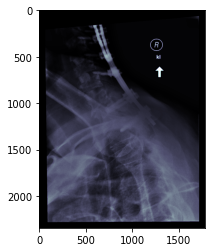

In [147]:
branded_dcm[branded_dcm['ViewPosition']=='SWIMMERS']
print("\tSWIMMERS   ")
show_image('../cspine-det/data/dicoms_072919/Csp_00170_20131022/IM-2151-0001.dcm')

		AP OPEN MOUTH


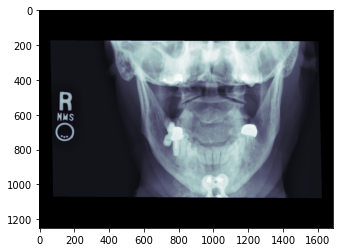

In [148]:
#branded_dcm[branded_dcm['ViewPosition']=='AP OPEN MOUTH']
print("\t\tAP OPEN MOUTH")
show_image('../cspine-det/data/dicoms_072919/Csp_00097_20180826/IM-0029-0001.dcm')

		XTABLE


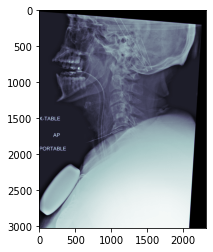

In [149]:
branded_dcm[branded_dcm['ViewPosition']=='XTABLE']
print("\t\tXTABLE")
show_image('../cspine-det/data/dicoms_072919/Csp_00015_20150901/IM-1571-0001.dcm')

		LPO


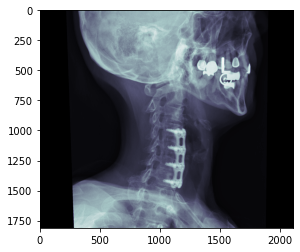

In [150]:
branded_dcm[branded_dcm['ViewPosition']=='LPO']
print("\t\tLPO")
show_image('../cspine-det/data/dicoms_072919/Csp_00102_20161202/IM-0873-0001.dcm')

		RPO


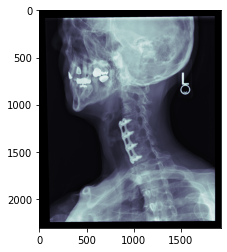

In [151]:
#branded_dcm[branded_dcm['ViewPosition']=='RPO']
print("\t\tRPO")
show_image('../cspine-det/data/dicoms_072919/Csp_00102_20161202/IM-0874-0001.dcm')

In [152]:
# Step 3: Drop views that are not AP, LATERAL, LATERAL FLEX, LATERAL EXT, LL
# Create new column indicating image view
views = ['AP', 'LATERAL','LATERAL FLEX', 'LATERAL EXT', 'LL']
branded_dcm = branded_dcm[branded_dcm['ViewPosition'].isin(views)]
print(f'\nRecords reduced to {branded_dcm.shape} after removal of other views.')   
print(f'\nUnique patients reduced to {len(branded_dcm["PatientID"].unique())} after removal of other views.')   


Records reduced to (1924, 19) after removal of other views.

Unique patients reduced to 186 after removal of other views.


		Odontoid Images

Records reduced to (1868, 19) after removal of odontoid images.

Unique patients reduced to 186 after removal of odontoid images.


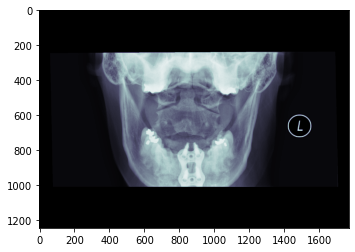

In [153]:
# Step 4: Drop Odontoid images
print("\t\tOdontoid Images")
show_image('../cspine-det/data/dicoms_072919/Csp_00173_20140618/IM-1901-0001.dcm')
branded_dcm=branded_dcm[branded_dcm['BodyPartExamined']!='ODONTOID']
print(f'\nRecords reduced to {branded_dcm.shape} after removal of odontoid images.')   
print(f'\nUnique patients reduced to {len(branded_dcm["PatientID"].unique())} after removal of odontoid images.')   

## Lateral vs. AP

		LATERAL


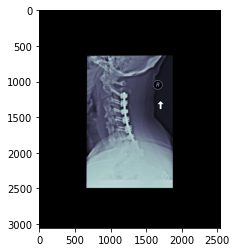

In [154]:
branded_dcm[branded_dcm['ViewPosition']=='LATERAL']
print("\t\tLATERAL")
show_image('../cspine-det/data/dicoms_072919/Csp_00069_20130127/IM-2419-0001.dcm')

	LATERAL FLEX


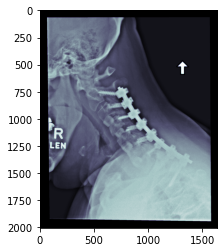

In [155]:
branded_dcm[branded_dcm['ViewPosition']=='LATERAL FLEX']
print("\tLATERAL FLEX")
show_image('../cspine-det/data/dicoms_072919/Csp_00069_20130630/IM-2277-0001.dcm')

	LATERAL EXT


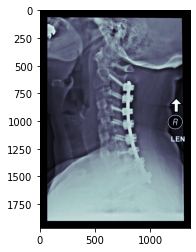

In [156]:
branded_dcm[branded_dcm['ViewPosition']=='LATERAL EXT']
print("\tLATERAL EXT")
show_image('../cspine-det/data/dicoms_072919/Csp_00069_20130630/IM-2278-0001.dcm')

		LL


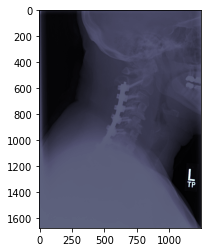

In [157]:
branded_dcm[branded_dcm['ViewPosition']=='LL']
print("\t\tLL")
show_image('../cspine-det/data/dicoms_072919/Csp_00069_20121223/IM-2433-0006.dcm')

		AP


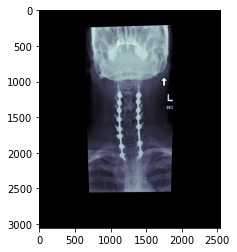

In [158]:
branded_dcm[branded_dcm['ViewPosition']=='AP']
print("\t\tAP")
show_image('../cspine-det/data/dicoms_072919/Csp_00069_20130127/IM-2418-0001.dcm')

	AP


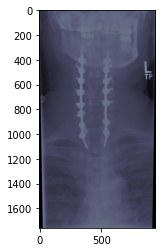

In [159]:
print("\tAP")
show_image('../cspine-det/data/dicoms_072919/Csp_00069_20121223/IM-2433-0009.dcm')

In [160]:
# Step 4: Drop views that are not AP, LATERAL, LATERAL FLEX, LATERAL EXT, LL
# Create new column indicating image view
views = ['AP', 'LATERAL','LATERAL FLEX', 'LATERAL EXT', 'LL']
branded_dcm = branded_dcm[branded_dcm['ViewPosition'].isin(views)]
for index, row in branded_dcm.iterrows():
    if (row['ViewPosition']=='AP'):
        branded_dcm.at[index,'View'] = 'AP'
    else:
        branded_dcm.at[index,'View'] = 'L'
  
      
# remove images where pixel array does not exist
no_pixels = ['../cspine-det/data/dicoms_072919/Csp_00075_20130622/IM-2297-0001-0002.dcm',
'../cspine-det/data/dicoms_072919/Csp_00075_20130622/IM-2297-0001-0003.dcm',
'../cspine-det/data/dicoms_072919/Csp_00075_20130622/IM-2297-0001-0005.dcm',
'../cspine-det/data/dicoms_072919/Csp_00075_20130622/IM-2297-0001-0004.dcm',
'../cspine-det/data/dicoms_072919/Csp_00001_20130622/IM-2288-0001-0005.dcm',
'../cspine-det/data/dicoms_072919/Csp_00001_20130622/IM-2288-0001-0004.dcm',
'../cspine-det/data/dicoms_072919/Csp_00001_20130622/IM-2288-0001-0002.dcm',
'../cspine-det/data/dicoms_072919/Csp_00001_20130622/IM-2288-0001-0003.dcm']

for dcm in no_pixels:
    branded_dcm = branded_dcm.drop(branded_dcm[branded_dcm['filepath']==dcm].index)

print(f'\nRecords reduced to {branded_dcm.shape} after removal images without pixels.')   
print(f'\nUnique patients reduced to {len(branded_dcm["PatientID"].unique())} after removal of images without pixels.')      
display(branded_dcm.head(5))


Records reduced to (1860, 20) after removal images without pixels.

Unique patients reduced to 186 after removal of images without pixels.


,filepath,SOPClassUID,SOPInstanceUID,StudyDate,Modality,StudyDescription,SeriesDescription,PatientID,Patient'sBirthDate,Patient'sSex,BodyPartExamined,ViewPosition,StudyInstanceUID,SeriesInstanceUID,PatientOrientation,Anonymized DOS,Anterior HDW,Posterior HDW,Cage,View
0,../cspine-det/data/dicoms_072919/Csp_00069_20130127/IM-2418-0001.dcm,1.2.840.10008.5.1.4.1.1.1,2.16.840.1.113669.632.21.1396024793.1396024793.34523878562548110,2013-01-27,CR,XR SPINE CERVICAL 2-3 VIEWS,AP,CSP_00069,NaN,NaN,C SPINE,AP,2.16.840.1.113669.632.21.1396024793.1396024793.26159062962046250,2.16.840.1.113669.632.21.1396024793.1396024793.34356800212136354,"['L', 'F']",2012-12-21,NaN,Vertex,NaN,AP
1,../cspine-det/data/dicoms_072919/Csp_00069_20130127/IM-2419-0001.dcm,1.2.840.10008.5.1.4.1.1.1,2.16.840.1.113669.632.21.1396024793.1396024793.22817195932698770,2013-01-27,CR,XR SPINE CERVICAL 2-3 VIEWS,LATERAL,CSP_00069,NaN,NaN,C SPINE,LATERAL,2.16.840.1.113669.632.21.1396024793.1396024793.26159062962046250,2.16.840.1.113669.632.21.1396024793.1396024793.22994831802286994,"['L', 'F']",2012-12-21,NaN,Vertex,NaN,L
2,../cspine-det/data/dicoms_072919/Csp_00069_20130630/IM-2278-0001.dcm,1.2.840.10008.5.1.4.1.1.1,2.16.840.1.113669.632.21.1396024793.1396024793.75284651326181701,2013-06-30,CR,XR Spine Cervical 4-5 Views,LATERAL EXT,CSP_00069,NaN,NaN,C SPINE,LATERAL EXT,2.16.840.1.113669.632.21.1396024793.1396024793.17963111972127050,2.16.840.1.113669.632.21.1396024793.1396024793.76943096422062791,"['L', 'F']",2012-12-21,NaN,Vertex,NaN,L
3,../cspine-det/data/dicoms_072919/Csp_00069_20130630/IM-2276-0001.dcm,1.2.840.10008.5.1.4.1.1.1,2.16.840.1.113669.632.21.1396024793.1396024793.19841116925279901,2013-06-30,CR,XR Spine Cervical 4-5 Views,LATERAL,CSP_00069,NaN,NaN,C SPINE,LATERAL,2.16.840.1.113669.632.21.1396024793.1396024793.17963111972127050,2.16.840.1.113669.632.21.1396024793.1396024793.18196496421159591,"['L', 'F']",2012-12-21,NaN,Vertex,NaN,L
4,../cspine-det/data/dicoms_072919/Csp_00069_20130630/IM-2277-0001.dcm,1.2.840.10008.5.1.4.1.1.1,2.16.840.1.113669.632.21.1396024793.1396024793.15404579682698940,2013-06-30,CR,XR Spine Cervical 4-5 Views,LATERAL FLEX,CSP_00069,NaN,NaN,C SPINE,LATERAL FLEX,2.16.840.1.113669.632.21.1396024793.1396024793.17963111972127050,2.16.840.1.113669.632.21.1396024793.1396024793.15245370772286909,"['L', 'F']",2012-12-21,NaN,Vertex,NaN,L


In [162]:
branded_dcm['BodyPartExamined'].value_counts()

C SPINE                        1459
CSPINE                          378
AA                               15
T SPINE                           3
XR Spine Cervical 2-3 Views       3
XR S C 23 V                       2
Name: BodyPartExamined, dtype: int64

In [163]:
print(f'Study dates range from {branded_dcm["StudyDate"].min()} tp {branded_dcm["StudyDate"].max()}')
print(f'\nDate with most images collected {branded_dcm["StudyDate"].value_counts()[0:1]}')

Study dates range from 2009-11-21 00:00:00 tp 2018-08-19 00:00:00

Date with most images collected 2017-01-07    17
Name: StudyDate, dtype: int64


In [164]:
print(f'Dates of surgery range from {branded_dcm["Anonymized DOS"].min()} tp {branded_dcm["StudyDate"].max()}')

Dates of surgery range from 2009-11-20 00:00:00 tp 2018-08-19 00:00:00


In [165]:
branded_dcm['Modality'].value_counts()

CR    1459
DX     399
OT       2
Name: Modality, dtype: int64

In [166]:
print(f'{len(branded_dcm["StudyDescription"].unique())} unique studies')
branded_dcm['StudyDescription'].value_counts()

6 unique studies


XR Spine Cervical 4-5 Views                929
XR SPINE CERVICAL 2-3 VIEWS                917
XR SPINE CERVICAL 1 VIEW                     4
XR SPINE CERVICAL 2-3 VWS STND PROTOCOL      4
XR Spine Cervical 2-3 Vws Stnd Protocol      3
XR Spine Cervical 2-3 Views                  3
Name: StudyDescription, dtype: int64

In [167]:
print(f'{len(branded_dcm["SeriesDescription"].unique())} unique views')
display(branded_dcm['SeriesDescription'].value_counts())
print(20*'-')
print("views reduced to AP or L")
print(f'{len(branded_dcm["View"].unique())} unique views')
display(branded_dcm['View'].value_counts())

6 unique views


LATERAL                        424
Cervical-spine                 393
LATERAL FLEX                   355
LATERAL EXT                    348
AP                             335
XR Spine Cervical 2-3 Views      5
Name: SeriesDescription, dtype: int64

--------------------
views reduced to AP or L
2 unique views


L     1280
AP     580
Name: View, dtype: int64

In [168]:
print(f'{len(branded_dcm["BodyPartExamined"].unique())} unique body part examined')
branded_dcm['BodyPartExamined'].value_counts()

6 unique body part examined


C SPINE                        1459
CSPINE                          378
AA                               15
T SPINE                           3
XR Spine Cervical 2-3 Views       3
XR S C 23 V                       2
Name: BodyPartExamined, dtype: int64

In [169]:
print(f'{len(branded_dcm["PatientID"].unique())} unique patients')
branded_dcm['PatientID'].value_counts()

186 unique patients


CSP_00140    34
CSP_00090    31
CSP_00179    30
CSP_00075    29
CSP_00132    28
             ..
CSP_00055     2
CSP_00147     2
CSP_00160     2
CSP_00008     2
CSP_00010     1
Name: PatientID, Length: 186, dtype: int64

In [170]:
print(f'{len(branded_dcm[branded_dcm["PatientOrientation"].notna()]["PatientOrientation"].unique())} unique patient orientations')
branded_dcm['PatientOrientation'].value_counts()

3 unique patient orientations


['L', 'F']    1128
['A', 'F']     710
['P', 'F']      19
Name: PatientOrientation, dtype: int64

In [171]:
print(f'{len(branded_dcm[branded_dcm["Anterior HDW"].notna()]["Anterior HDW"].unique())} unique Anterior HDW brands')
branded_dcm['Anterior HDW'].value_counts()

5 unique Anterior HDW brands


ATLANTIS    1084
ARCHON       369
MAXAN        210
ZEVO          22
HELIX          6
Name: Anterior HDW, dtype: int64

In [172]:
print(f'{len(branded_dcm[branded_dcm["Posterior HDW"].notna()]["Posterior HDW"].unique())} unique Posterior HDW brands')
branded_dcm['Posterior HDW'].value_counts()

6 unique Posterior HDW brands


MOUNTAINEER           155
ARCH                   37
Vertex                 27
VIRAGE                 11
Centerpiece/Vertex      7
OASYS                   6
Name: Posterior HDW, dtype: int64

In [173]:
print(f'{len(branded_dcm[branded_dcm["Cage"].notna()]["Cage"].unique())} unique Cage brands')
branded_dcm['Cage'].value_counts()

1 unique Cage brands


Nuvasive    3
Name: Cage, dtype: int64

In [174]:
branded_dcm[branded_dcm["Anterior HDW"] =='Vertex']['PatientID'].count()

0

## Print AP and L views of different brands

### Anterior Brands

	ATLANTIS (L)


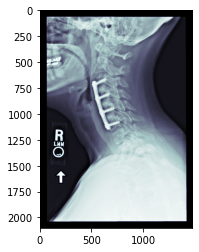

In [698]:
print('\tATLANTIS (L)')
show_image('../cspine-det/data/dicoms_072919/Csp_00173_20140802/IM-1884-0001.dcm')

	ATLANTIS (AP)


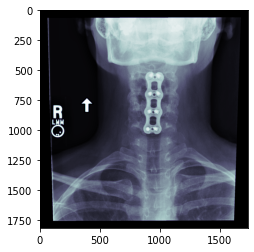

In [700]:
print('\tATLANTIS (AP)')
show_image('../cspine-det/data/dicoms_072919/Csp_00173_20140802/IM-1883-0001.dcm')

	ARCHON (L)


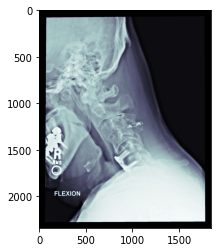

In [702]:
print('\tARCHON (L)')
show_image('../cspine-det/data/dicoms_072919/Csp_00113_20171209/IM-0349-0001.dcm')

	ARCHON (AP)


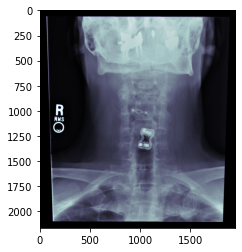

In [704]:
print('\tARCHON (AP)')
show_image('../cspine-det/data/dicoms_072919/Csp_00113_20171209/IM-0347-0001.dcm')

	MAXAN (L)


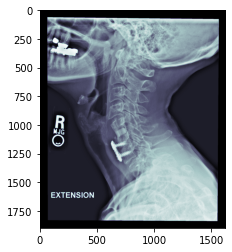

In [706]:
print('\tMAXAN (L)')
show_image('../cspine-det/data/dicoms_072919/Csp_00094_20141227/IM-1755-0001.dcm')

	MAXAN (AP)


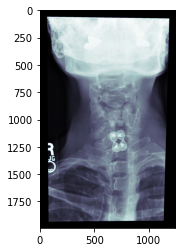

In [709]:
print('\tMAXAN (AP)')
show_image('../cspine-det/data/dicoms_072919/Csp_00094_20141227/IM-1756-0001.dcm')

	HELIX (L)


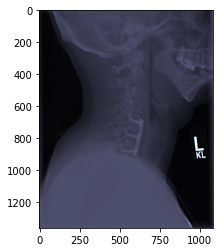

In [175]:
print('\tHELIX (L)')
show_image('../cspine-det/data/dicoms_072919/Csp_00036_20110426/IM-2599-0001.dcm')

	HELIX (AP)


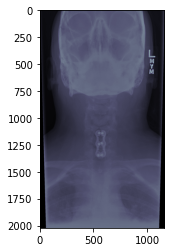

In [176]:
print('\tHELIX (AP)')
show_image('../cspine-det/data/dicoms_072919/Csp_00033_20110409/IM-0002-0001.dcm')

	ZEVO (L)


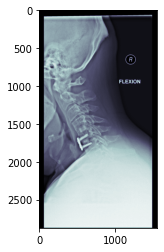

In [177]:
print('\tZEVO (L)')
show_image('../cspine-det/data/dicoms_072919/Csp_00015_20151018/IM-1517-0001.dcm')

	ZEVO (L)


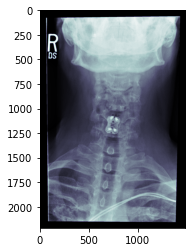

In [178]:
print('\tZEVO (L)')
show_image('../cspine-det/data/dicoms_072919/Csp_00015_20160430/IM-1219-0001.dcm')

### Posterior Brands

	MOUNTAINEER (L)


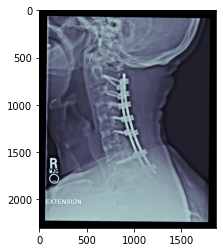

In [712]:
print('\tMOUNTAINEER (L)')
show_image('../cspine-det/data/dicoms_072919/Csp_00170_20150103/IM-1745-0001.dcm')

	MOUNTAINEER (AP)


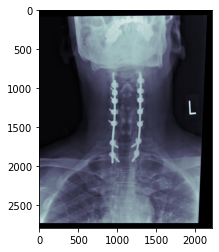

In [714]:
print('\tMOUNTAINEER (AP)')
show_image('../cspine-det/data/dicoms_072919/Csp_00170_20180303/IM-0238-0001.dcm')

	Arch (L)


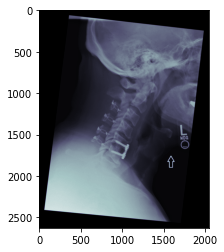

In [185]:
print('\tArch (L)')
show_image('../cspine-det/data/dicoms_072919/Csp_00157_20161204/IM-0846-0001.dcm')

	Arch (AP)


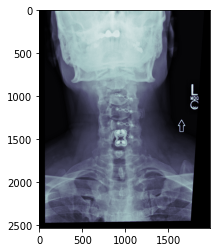

In [187]:
print('\tArch (AP)')
show_image('../cspine-det/data/dicoms_072919/Csp_00157_20161204/IM-0845-0001.dcm')

	Vertex (L)


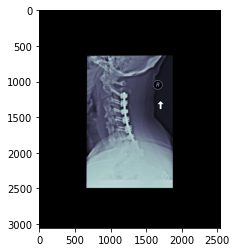

In [716]:
print('\tVertex (L)')
show_image('../cspine-det/data/dicoms_072919/Csp_00069_20130127/IM-2419-0001.dcm')

	Vertex (AP)


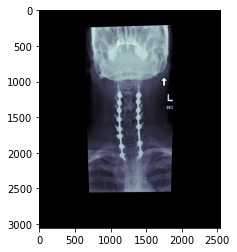

In [718]:
print('\tVertex (AP)')
show_image('../cspine-det/data/dicoms_072919/Csp_00069_20130127/IM-2418-0001.dcm')

	Virage (L)


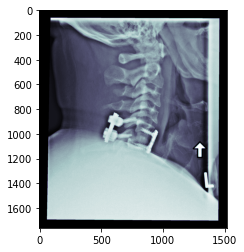

In [191]:
print('\tVirage (L)')
show_image('../cspine-det/data/dicoms_072919/Csp_00108_20151121/IM-1489-0001.dcm')

	Virage (AP)


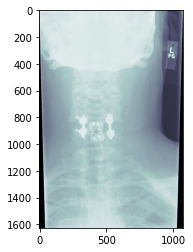

In [189]:
print('\tVirage (AP)')
show_image('../cspine-det/data/dicoms_072919/Csp_00108_20150829/IM-1585-0002.dcm')

	Oasys (L)


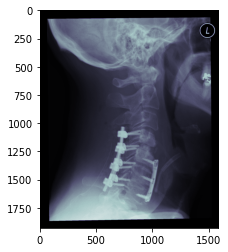

In [195]:
print('\tOasys (L)')
show_image('../cspine-det/data/dicoms_072919/Csp_00184_20160315/IM-1297-0001.dcm')

	Oasys (AP)


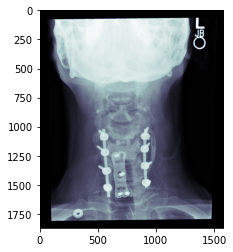

In [196]:
print('\tOasys (AP)')
show_image('../cspine-det/data/dicoms_072919/Csp_00184_20160315/IM-1298-0001.dcm')

	Centerpiece/Vertex (AP)


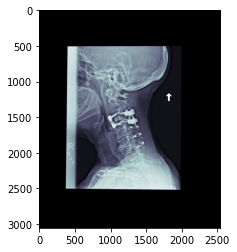

In [199]:
print('\tCenterpiece/Vertex (AP)')
show_image('../cspine-det/data/dicoms_072919/Csp_00030_20130324/IM-2382-0001.dcm')

	Centerpiece/Vertex (AP)


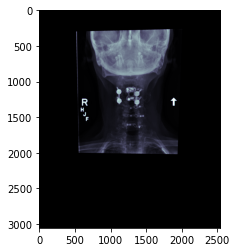

In [200]:
print('\tCenterpiece/Vertex (AP)')
show_image('../cspine-det/data/dicoms_072919/Csp_00030_20130324/IM-2381-0001.dcm')

In [3]:
# Read anterior master data
anterior =pd.read_csv('Master_Anterior_HDW.csv')
display(anterior.head(5))
print(anterior.shape)
anterior.loc[anterior['Brand'] == 'ATLANTIS ', 'Brand'] = 'ATLANTIS'
print(anterior['Brand'].value_counts())

,PatientID,filepath,Label,View,Multiple,Brand,SeriesInstanceUID,ViewPosition
0,CSP_00173,../cspine-det/data/dicoms_072919/Csp_00173_20140802/IM-1884-0001.dcm,0.0,L,0.0,ATLANTIS,2.16.840.1.113669.632.21.1110812115.1110812115.33562637672005680,LATERAL
1,CSP_00173,../cspine-det/data/dicoms_072919/Csp_00173_20140802/IM-1883-0001.dcm,0.0,AP,0.0,ATLANTIS,2.16.840.1.113669.632.21.1110812115.1110812115.33557435752075830,AP
2,CSP_00173,../cspine-det/data/dicoms_072919/Csp_00173_20140802/IM-1882-0001.dcm,0.0,L,0.0,ATLANTIS,2.16.840.1.113669.632.21.1110812115.1110812115.33589064372125850,LATERAL EXT
3,CSP_00173,../cspine-det/data/dicoms_072919/Csp_00173_20140802/IM-1881-0001.dcm,0.0,L,0.0,ATLANTIS,2.16.840.1.113669.632.21.1110812115.1110812115.12946525932236970,LATERAL FLEX
4,CSP_00173,../cspine-det/data/dicoms_072919/Csp_00173_20141220/IM-1764-0001.dcm,0.0,L,0.0,ATLANTIS,2.16.840.1.113669.632.21.1110812115.1110812115.17652876042126233,LATERAL


(1643, 8)
ATLANTIS    1051
ARCHON       365
MAXAN        200
ZEVO          22
HELIX          5
Name: Brand, dtype: int64


In [4]:
data = {'Brand': ['ATLANTIS', 'ARCHON', 'MAXAN', 'ZEVO', 'HELIX'],
        
        'Unique_Patients': [len(anterior[anterior["Brand"] =='ATLANTIS']['PatientID'].unique()),
                            len(anterior[anterior["Brand"] =='ARCHON']['PatientID'].unique()),
                             len(anterior[anterior["Brand"] =='MAXAN']['PatientID'].unique()),
                             len(anterior[anterior["Brand"] =='ZEVO']['PatientID'].unique()),
                             len(anterior[anterior["Brand"] =='HELIX']['PatientID'].unique())
                             ],
        
        'ImageCounts' : [anterior[anterior["Brand"] =='ATLANTIS']['PatientID'].count(),
                          anterior[anterior["Brand"] =='ARCHON']['PatientID'].count(),
                          anterior[anterior["Brand"] =='MAXAN']['PatientID'].count(),
                          anterior[anterior["Brand"] =='ZEVO']['PatientID'].count(),
                          anterior[anterior["Brand"] =='HELIX']['PatientID'].count()
                         ],
        
        'L_counts' : [anterior[(anterior["Brand"] =='ATLANTIS')&(anterior["View"]=='L')]['PatientID'].count(),
                          anterior[(anterior["Brand"] =='ARCHON')&(anterior["View"]=='L')]['PatientID'].count(),
                          anterior[(anterior["Brand"] =='MAXAN')&(anterior["View"]=='L')]['PatientID'].count(),
                          anterior[(anterior["Brand"] =='ZEVO')&(anterior["View"]=='L')]['PatientID'].count(),
                          anterior[(anterior["Brand"] =='HELIX')&(anterior["View"]=='L')]['PatientID'].count()
                         ],
        
        'AP_counts' : [anterior[(anterior["Brand"] =='ATLANTIS')&(anterior["View"]=='AP')]['PatientID'].count(),
                          anterior[(anterior["Brand"] =='ARCHON')&(anterior["View"]=='AP')]['PatientID'].count(),
                          anterior[(anterior["Brand"] =='MAXAN')&(anterior["View"]=='AP')]['PatientID'].count(),
                          anterior[(anterior["Brand"] =='ZEVO')&(anterior["View"]=='AP')]['PatientID'].count(),
                          anterior[(anterior["Brand"] =='HELIX')&(anterior["View"]=='AP')]['PatientID'].count()
                          ]
       }
pd.DataFrame(data, columns = ['Brand', 'Unique_Patients','ImageCounts', 'L_counts','AP_counts'], index=None)

,Brand,Unique_Patients,ImageCounts,L_counts,AP_counts
0,ATLANTIS,119,1051,696,355
1,ARCHON,29,365,249,116
2,MAXAN,12,200,146,54
3,ZEVO,2,22,15,7
4,HELIX,2,5,2,3


In [5]:
# Read posterior master data
posterior =pd.read_csv('Master_Posterior_HDW.csv')
display(posterior.head(5))
print(posterior.shape)
print(posterior['Brand'].value_counts())

,PatientID,filepath,Label,View,Multiple,Brand,SeriesInstanceUID,ViewPosition
0,CSP_00069,../cspine-det/data/dicoms_072919/Csp_00069_20130127/IM-2418-0001.dcm,2.0,AP,0.0,Vertex,2.16.840.1.113669.632.21.1396024793.1396024793.34356800212136354,AP
1,CSP_00069,../cspine-det/data/dicoms_072919/Csp_00069_20130127/IM-2419-0001.dcm,2.0,L,0.0,Vertex,2.16.840.1.113669.632.21.1396024793.1396024793.22994831802286994,LATERAL
2,CSP_00069,../cspine-det/data/dicoms_072919/Csp_00069_20130630/IM-2278-0001.dcm,2.0,L,0.0,Vertex,2.16.840.1.113669.632.21.1396024793.1396024793.76943096422062791,LATERAL EXT
3,CSP_00069,../cspine-det/data/dicoms_072919/Csp_00069_20130630/IM-2276-0001.dcm,2.0,L,0.0,Vertex,2.16.840.1.113669.632.21.1396024793.1396024793.18196496421159591,LATERAL
4,CSP_00069,../cspine-det/data/dicoms_072919/Csp_00069_20130630/IM-2277-0001.dcm,2.0,L,0.0,Vertex,2.16.840.1.113669.632.21.1396024793.1396024793.15245370772286909,LATERAL FLEX


(230, 8)
MOUNTAINEER           148
ARCH                   37
Vertex                 23
VIRAGE                 10
Centerpiece/Vertex      6
OASYS                   6
Name: Brand, dtype: int64


In [6]:
data = {'Brand': ['MOUNTAINEER', 'ARCH', 'VERTEX', 'VIRAGE', 'OASYS', 'CENTERPIECE/VERTEX'],
        
        'Unique_Patients': [len(posterior[posterior["Brand"] =='MOUNTAINEER']['PatientID'].unique()),
                            len(posterior[posterior["Brand"] =='ARCH']['PatientID'].unique()),
                             len(posterior[posterior["Brand"] =='Vertex']['PatientID'].unique()),
                             len(posterior[posterior["Brand"] =='VIRAGE']['PatientID'].unique()),
                             len(posterior[posterior["Brand"] =='OASYS']['PatientID'].unique()),
                            len(posterior[posterior["Brand"] =='Centerpiece/Vertex']['PatientID'].unique())
                             ],
        
        'ImageCounts' : [posterior[posterior["Brand"] =='MOUNTAINEER']['PatientID'].count(),
                          posterior[posterior["Brand"] =='ARCH']['PatientID'].count(),
                          posterior[posterior["Brand"] =='Vertex']['PatientID'].count(),
                          posterior[posterior["Brand"] =='VIRAGE']['PatientID'].count(),
                          posterior[posterior["Brand"] =='OASYS']['PatientID'].count(),
                          posterior[posterior["Brand"] =='Centerpiece/Vertex']['PatientID'].count()
                         ],
        
        'L_counts' : [posterior[(posterior["Brand"] =='MOUNTAINEER')&(posterior["View"]=='L')]['PatientID'].count(),
                          posterior[(posterior["Brand"] =='ARCH')&(posterior["View"]=='L')]['PatientID'].count(),
                          posterior[(posterior["Brand"] =='Vertex')&(posterior["View"]=='L')]['PatientID'].count(),
                          posterior[(posterior["Brand"] =='VIRAGE')&(posterior["View"]=='L')]['PatientID'].count(),
                          posterior[(posterior["Brand"] =='OASYS')&(posterior["View"]=='L')]['PatientID'].count(),
                          posterior[(posterior["Brand"] =='Centerpiece/Vertex')&(posterior["View"]=='L')]['PatientID'].count()
                         ],
        
        'AP_counts' : [posterior[(posterior["Brand"] =='MOUNTAINEER')&(posterior["View"]=='AP')]['PatientID'].count(),
                          posterior[(posterior["Brand"] =='ARCH')&(posterior["View"]=='AP')]['PatientID'].count(),
                          posterior[(posterior["Brand"] =='Vertex')&(posterior["View"]=='AP')]['PatientID'].count(),
                          posterior[(posterior["Brand"] =='VIRAGE')&(posterior["View"]=='AP')]['PatientID'].count(),
                          posterior[(posterior["Brand"] =='OASYS')&(posterior["View"]=='AP')]['PatientID'].count(),
                          posterior[(posterior["Brand"] =='Centerpiece/Vertex')&(posterior["View"]=='AP')]['PatientID'].count()
                          ]
       }
pd.DataFrame(data, columns = ['Brand', 'Unique_Patients','ImageCounts', 'L_counts','AP_counts'], index=None)

,Brand,Unique_Patients,ImageCounts,L_counts,AP_counts
0,MOUNTAINEER,12,148,112,36
1,ARCH,4,37,27,10
2,VERTEX,3,23,16,7
3,VIRAGE,1,10,7,3
4,OASYS,1,6,4,2
5,CENTERPIECE/VERTEX,1,6,4,2
